* Youtube Video - https://www.youtube.com/watch?v=psmMEWKk4Uk&t=1584s
* DINO Github - https://github.com/facebookresearch/dino
* ImageNette Data - https://github.com/fastai/imagenette
* Paper: https://arxiv.org/abs/2104.14294
* Vision Transformer code: https://github.com/rwightman/pytorch
* Main Repo - https://github.com/jankrepl/mildlyoverfitted/tree/master/github_adventures/dino
* PT models - https://github.com/huggingface/pytorch-image-models
* Theory Vid - https://www.youtube.com/watch?v=h3ij3F3cPIk

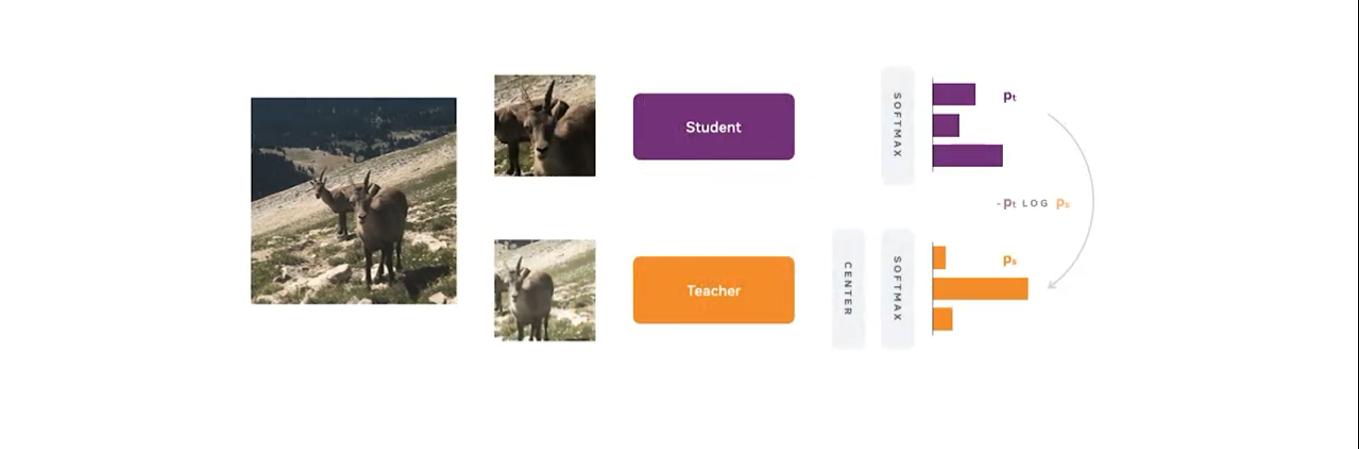

# Augmentations Implemented

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image

In [ ]:
class DataAugmentation:
    """Create crops of an input image together with additional augmentation.
    It generates 2 global crops and 'n_local_crops' local crops.
    
    Parameters
    ----------
    global_crops_scale: tuple
        Range of sizes for the global crops.
        
    local_crops_scale : tuple
        Range of sizes for the local crops.
        
    n_local_crops : int
        Number of local crops to create.
        
    size : int
        The size of the final image.
    """
    def __init__(
        self,
        global_crops_scale = (0.4 , 1),
        local_crops_scale = (0.05 , 0.4),
        n_local_crops = 8,
        size = 224
    ):
        self.n_local_crops = n_local_crops
        
        RandomGaussianBlur = lambda p : transforms.RandomApply(
            [transforms.GaussianBlur(kernel_size = 5 , sigma = (0.1 , 2))],
            p = p
        )
        
        flip_and_jitter = transforms.Compose([
            transforms.RandomHorizontalFlip(p = .5),
            transforms.RandomApply([
                transforms.ColorJitter(brightness = 0.4 , contrast = 0.4 , saturation = 0.2 , hue = 0.1)
            ]),
            transforms.RandomGrayscale( p = 0.2)
        ])
        
        normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.485 , 0.456 , 0.406),(0.229 , 0.224 , 0.225))
        ])
        
        self.global_1 = transforms.Compose([
            transforms.RandomResizedCrop(size , scale = global_crops_scale , interpolation = Image.BICUBIC),
            flip_and_jitter,
            RandomGaussianBlur(1.0) , # Always apply
            normalize
        ])
        
        self.global_2 = transforms.Compose([
            transforms.RandomResizedCrop(size , scale = global_crops_scale , interpolation = Image.BICUBIC),
            flip_and_jitter,
            RandomGaussianBlur(0.1) , # Always apply
            transforms.RandomSolarize(170 , p = 0.2),
            normalize
        ])
        
        self.local = transforms.Compose([
            transforms.RandomResizedCrop(size , scale = local_crops_scale , interpolation = Image.BICUBIC),
            flip_and_jitter,
            RandomGaussianBlur(0.5) , # Always apply
            normalize
        ])
        
    def __call__(self, img):
        """Apply transformation.
        
        Parameters
        ----------
        img: PIL.Image
            Input image.
        
        Returns
        -------
        all_crops: list
            List of 'torch.Tensor' representation different views of the input `img`. 
        """
        all_crops = []
        all_crops.append(self.global_1(img))
        all_crops.append(self.global_2(img))
        
        all_crops.extend([self.local(img) for _ in range(self.n_local_crops)])
        
        return all_crops

In [ ]:
import ipywidgets
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder

transform = DataAugmentation(n_local_crops=2)
dataset = ImageFolder("/kaggle/input/imagenette/imagenette/train", transform=transform)

def to_numpy(t):
    array = torch.clip((t * 0.224) + 0.45, 0, 1).permute(1, 2, 0).numpy()
    return array

@ipywidgets.interact
def _(
    i=ipywidgets.IntSlider(min=0, max=len(dataset) - 1, continuous_update=False),
    seed=ipywidgets.IntSlider(min=0, max=50, continuous_update=False),
):
    torch.manual_seed(seed)
    all_crops, _ = dataset[i]
    titles = ["Global 1", "Global 2", "Local 1", "Local 2"]
    
    original_img = np.array(Image.open(dataset.samples[i][0]))
    _, ax_orig = plt.subplots(figsize=(15, 5))
    ax_orig.imshow(original_img)
    ax_orig.set_title("Original")
    ax_orig.axis("off")
    
    
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    
    for i, title in enumerate(titles):
        ax = axs[i // 2, i % 2]
        ax.imshow(to_numpy(all_crops[i]))
        ax.set_title(title)
        ax.axis("off")
    fig.tight_layout()

# Head Implementation (VIT)

In [ ]:
class Head(nn.Module):
    """Network hooked up tp the CLS token embedding.
    Just a MLP with the last layer being normalized in a particular way.
    
    Parameters
    ----------
    in_dim: int
        The dimensionality of the token embedding.
        
    out_dim: int
        The dimensionality of the final layer (we compute the softmax over).
    
    hidden_dim: int
        Dimensionality of the hidden layers.
    
    bottleneck_dim:int 
        Dimensionality of the second last layer.
        
    n_layers:int
        The number of layers.
        
    norm_last_layer:bool
        If True, then we freeze the norm of the weight of the last linear layer to 1.
        
    Attributes
    ----------
    mlp : nn.Sequential
        Vanilla multi-layer perceptron.
    
    last_layer: nn.Linear
        Reparametrized linear layer with weight normalization. That means that it will have 'weight_g' and 'weight_v' as learnable parameters instead of a single 'weight'.
    """
    def __init__(
        self,
        in_dim,
        out_dim,
        hidden_dim=512,
        bottleneck_dim=256,
        n_layers=3,
        norm_last_layer=False
    ):
        super().__init__()
        if n_layer == 1:
            self.mlp = nn.Linear(in_dim , bottleneck_dim)
        else:
            layers = [nn.Linear(in_dim , hidden_dim)]
            layers.append(nn.GELU())
            for _ in range(n_layers - 2):
                layers.append(nn.Linear(hidden_dim,hidden_dim))
                layers.append(nn.GELU())
            layers.append(nn.Linear(hidden_dim , bottleneck_dim))
            self.mlp = nn.Sequential(*layers)
        
        self.apply(self._init_weights)
        self.last_layer = nn.utils.weight_norm(
            nn.Linear(bottleneck_dim, out_dim, bias = False)
        )
        
        self.last_layer.weight_g.data.fill_(1)
        if norm_last_layer:
            self.last_layer.weight_g.requires_grad = False
    def _init_weights(self,m):
        """Initializing learnable parameters."""
        if isinstance(m,nn.Linear):
            if m.bias is not None:
                nn.init.constant_(m.bias , 0)
    def forward(self , x):
        """Run forward pass.
        
        Parameters
        ----------
        x: torch.Tensor
            Of shape `(n_samples, in_dim)`
        
        Returns
        -------
        torch.Tensor
            Of shape `(n_samples, out_dim)`
        """
        x = self.mlp(x) # (n_samples, bottleneck_dim)
        x = nn.functional.normalize(x, dim=-1 , p = 2) # (n_samples, bottleneck_dim)
        x = self.last_layer(x) # (n_samples, out_dim)
        return x

> Search more about weight normalization

### Break

In [ ]:
from torch.nn.utils import weight_norm

in_features, out_features = 2, 3
m = torch.nn.Linear(in_features,out_features , bias = False)
m_copy = torch.nn.Linear(in_features,out_features , bias = False)
# Make both have the same params
m_copy.load_state_dict(m.state_dict())

print('#################Before weight_norm#################')
print(list(m.named_parameters()) , list(m_copy.named_parameters()))
print('#################After weight_norm#################')
m_copy = weight_norm(m_copy)
print(list(m.named_parameters()) , list(m_copy.named_parameters()))

# weight_v > direction
# weight_g > magnitude
print('#################After weight_norm & still have weight(not a parameter anymore)#################')
# then its Calculated from weight_v , weight_g
print(m_copy.weight)

print("Hooks")
print(m._forward_pre_hooks)
print(m_copy._forward_pre_hooks)

# Applying optimizer
opt = torch.optim.SGD(m_copy.parameters() , lr = 0.1)
m_copy(torch.rand(5 , 2)).sum().backward()
print("Before Applying Optimizer")
print(m_copy.weight_v)
print("After Applying Optimizer")
opt.step()
print(m_copy.weight_v)


# MultiCropWrapper

In [ ]:
class MultiCropWrapper(nn.Module):
    """Convenience class for forward pass of multiple corss.
    
    Parameters
    ----------
    backbone: timm.models.vision_transformer.VisionTransformer
        Instantiated Vision Transformer. Note that we will take the `head` attribute and replace it with 'nn.Identity'
    
    new_head: Head
        Now head that is going to be put on top of the 'backbone'    
    """
    
    def __init__(self , backbone , new_head):
        super().__init__()
        backbone.head = nn.Identity() # Desactivate original head
        self.backbone = backbone
        self.new_head = new_head
        
    def forward(self, x):
        """Run the forward pass.
        The different crop are concatenated along the batch dimension and then a single forward pass is run. The resulting tensor is then chuncked back to per crop tensors.
        
        Parameters
        ----------
        x: list
            List of `torch.Tensor` each of shape `(n_samples, 3, size, size)`
        
        Returns
        -------
        tuple
            Tuple of `torch.Tensor` each of shape `(n_samples, out_dim)` where `output_dim` is determined by `Head`.
        """
        n_crops = len(x)
        concatenated = torch.cat(x, dim = 0) # (n_samples * n_crops , 3 , size , size)
        cls_embedding = self.backbone(concatenated) # (n_samples * n_crops , in_dim)
        logits = self.new_head(cls_embedding) # (n_samples * n_crops , out_dim)
        chunks = logits.chunk(n_crops) # n_crops * (n_samples, out_dim)
        
        return chunks

### Breake (Buffers in PyTorch)

In [ ]:
import torch
class GreatModule(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.m = torch.nn.Linear(2,3)
        self.p = torch.nn.Parameter(torch.rand(1,4))
        self.t = torch.rand(2,4)
        self.register_buffer('b' , torch.rand(2,2)) # Not trainable inside the model
        
module = GreatModule()
print(list(module.named_modules()))
print('\n')
print(list(module.named_parameters()))
print('\n')
print(list(module.named_buffers()))
print('\n')
print(module.state_dict()) # you can see the buffer in the state_dict (can be saved)

In [ ]:
bn = torch.nn.BatchNorm1d(10)
print(list(bn.named_parameters()))
print('\n')
print(list(bn.named_buffers()))

# Loss Function

In [ ]:
class Loss(nn.Module):
    """The loss function.
    We subclass the `nn.Module` because we want to create a buffer for the logits center of the teacher.
    
    Parameters
    ----------
    out_dim: int
        The dimensionlaity of the final layer (we computed the softmax over).
        
    teacher_temp, student_temp:float
        Softmax temperature of the teacher resp. student.
    
    conter_momentum: float
        Hyperparameters for the exponential moving average that determines the center logits. The higher the more the running average matters.
    """
    
    def __init__(
        self,
        out_dim,
        teacher_temp = 0.04,
        student_temp = 0.1,
        center_momentum=0.9
    ):
        super().__init__()
        self.student_temp = student_temp
        self.teacher_temp = teacher_temp
        self.center_momentum = center_momentum
        self.register_buffer('center',torch.zeros(1, out_dim))
        
    def forward(self, student_output , teacher_output):
        """Evaluate loss.
        
        Parameters
        ----------
        student_output, teacher_output: tuple
            Tuple of tensors of shape `(n_samples, out_dim)` representing logits. The length is equal to number of crops.
            Note that student processed all crops and that the two initial crops are the global ones.
        """
        student_temp = [s/self.student_temp for s in student_output]
        teacher_temp = [(t - self.center) / self.teacher_temp for t in teacher_output]
        
        student_sm = [F.log_softmax(s , dim =-1) for s in student_temp]
        teacher_sm = [F.softmax(t , dim =-1).detach() for t in teacher_temp]        
        
        total_loss = 0
        n_loss_terms = 0
        for t_ix , t in enumerate(teacher_sm):
            for s_ix, s in enumerate(student_sm):
                if t_ix == s_ix:
                    continue
                
                loss = torch.sum(-t * s, dim=-1) # (n_samples , )
                total_loss += loss.mean() # Scalar
                n_loss_terms += 1
        total_loss /= n_loss_terms
        self.update_center(teacher_output)
        return total_loss
    
    @torch.no_grad()
    def update_center(self , teacher_output):
        """Update center used for teacher output.
        Compute the exponential moving average.
        
        Parameters
        ----------
        teacher_output:list
            List of tensors of shape `(n_samples, out_dim)` where each tensor represents a different crop.
        """
        batch_center = torch.cat(teacher_output).mean(dim = 0, keepdim = True) # (1 , out_dim)
        self.center = self.center * self.conter_momentum + batch_center * (1 - self.center_momentum)

# Gradient Clipping

In [ ]:
def clip_gradient(model , clip = 2.0):
    """Rescale norm of computed gradients.
    Parameters
    ----------
    model: nn.Module
        Module.
    clip: float
        Maximum norm.    
    """
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm()
            clip_coef = clip / (param_norm + 1e-6)
            if clip_coef < 1 :
                p.grad.data.mul_(clip_coef)

# KNN Classifier

In [ ]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

def compute_knn(beckbone , data_loader_train , data_loader_val):
    """Get CLS embedding and use KNN classifier on them.
    We load all embedding in memory and use sklearn. Should be double.
    
    Parameters
    ----------
    backbone: timm.models.vision_transform.VisionTransformer
        Vision transformer whose head is just an identity mapping.
    
    data_loader_train, data_loader_val: torch.utils.DataLoader
        Training and validation dataloader that does not apply any augmentation. Just casting to tensor and then normalizing.
        
    Returns
    -------
    val_accuracy: float
        Validation accuracy.
    """
    
    device = next(backbone.parameters()).device
    data_loaders = {
        'train' : data_loader_train,
        'val':data_loader_val
    }
    lists = {
        'X_train':[],
        'y_train':[],
        'X_val':[],
        'y_val':[]
    }
    for name, data_loader in data_loaders.items():
        for imgs, y in data_loader:
            imgs = imgs.to(device)
            lists[f"X_{name}"].append(backbone(imgs).detach().cpu().nunmpy())
            lists[f"y_{name}"].append(y.detach().cpu().nunmpy())
            
    arrays = {k: np.concatenate(l) for k,l in lists.items()}
    
    estimator = KNeighborsClassifier()
    estimator.fit(array['X_train'] , arrays['y_train'])
    
    y_val_pred = estimator.predict(arrays['X_val'])
    
    acc = accuracy_score(arrays['y_val'] , y_val_pred)
    return acc

In [ ]:
def compute_embedding(backbone, data_loader):
    """Conpute CLS embedding and prepare for TensorBoard
    
    Parameters
    ----------
    backbone: timm.models.vision_transformer.VisionTransformer
        Vision Transformer.
        
    data_loader: torch.utils.data.DataLoader
        Validation dataloader that does not apply any augmentations. Just casting to tensor and then normalizing.
        
    Returns
    -------
    embs: torch.Tensor
        Embedding of shape `(n_samples, out_dim)`.
    imgs: torch.Tensor
        Images of shape `(n_samples, 3, height, width)`.
    labels: list
        List of strings reoresenting the classes.
    """
    device = next(backbone.parameters()).device
    
    embs_l = []
    imgs_l = []
    labels = []
    
    for img, y in data_loader:
        img = img.to(device)
        embs_l.append(backbone(img).detach())
        imgs_l.append(((img + 0.224) + 0.45).cpu()) # undo norm
        labels.extend([data_loader.dataset.classes[i] for i in y.tolist()])
        
    embs = torch.cat(embs_l, dim = 0)
    imgs = torch.cat(imgs_l, dim = 0) 
    
    return embs, imgs, labels

# Training

In [ ]:
import argparse
import json
import pathlib

import timm
import torch
import torchvision.transforms as transforms
import tqdm

from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.utils.tensroboard import SummaryWriter
from torchvision.datasets import ImageFolder

In [ ]:
def main():
    parser = argparser.ArgumentParser(
        "DINO training CLS",
        formatter_class = argparse.ArgumentDefaultsHelpFormatter
    )
    parser.add_argument("-b","--batch-size", type = int, dafault = 32)
    parser.add_argument("-d","--device", type = str,choices = ('cpu','cuda') ,dafault = 'cpu')
    parser.add_argument("-l","--loging-freq", type = int ,dafault = 200)
    parser.add_argument("--momentum-teacher", type = int ,dafault = 0.9995)
    parser.add_argument("-c","--n-crops", type = int ,dafault = 4)   
    parser.add_argument("-e","--n-epochs", type = int ,dafault = 100)
    parser.add_argument("-o","--out-dim", type = int ,dafault = 1024)    
    parser.add_argument("-t","--tensorboard-dir", type = str ,dafault = "logs")  
    parser.add_argument("--clip-grad", type = float ,dafault = 2.0)
    parser.add_argument("--norm-last-layer",action="store_true")
    parser.add_argument("--batch-size-eval",type = int , default = 64)  
    parser.add_argument("--teacher-temp",type = float , default = 0.04)   
    parser.add_argument("--student-temp",type = float , default = 0.1) 
    parser.add_argument("--pretrained",action = 'store_true')
    parser.add_argument("-w","--weight-decay", type = float ,dafault = 0.4)  
    
    args = parser.parse_args()
    print(vars(args))
    # Parameters
    vit_name, dim = "vit_deit_small_patch16_224" , 384
    path_dataset_train = pathlib.Path("data/imagenette2-320/train")
    path_dataset_val = pathlib.Path("data/imagenette2-320/val")
    path_labels = pathlib.Path("data/imagenette_labels.json")
    
    loggin_path = pathlib.Path(args.tensorboard_dir)
    device = torch.device(args.device)
    
    n_workers = 4
    
    # Data related
    with path_labels.open("r") as f:
        label_mapping = json.load(f)
        
    transform_aug = DataAugmentation(size = 224 , n_local_crops = args.n_crops - 2)
    transform_plain = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
        transforms.Resize((224,224))
    ])
    dataset_train_aug = ImageFolder(path_dataset_train, transform = transform_aug)
    dataset_train_plain = ImageFolder(path_dataset_train, transform = transform_plain)
    dataset_val_plain = ImageFolder(path_dataset_val, transform = transform_plain)
    
    if datast_train_plain.classes != dataset_val_plain.classes:
        raise ValueError("Inconsistent Classes")
        
    data_loader_train_aug = DataLoader(
        dataset_train_aug,
        batch_size = args.batch_size,
        shuffle = True,
        drop_last = True,
        num_workers = n_workers,
        pin_memory = True
    )
    data_loader_train_plain = DataLoader(
        dataset_train_plain,
        batch_size = args.batch_size_eval,
        drop_last = False,
        num_workers = n_workers,
    )
    data_loader_val_plain = DataLoader(
        dataset_val_plain,
        batch_size = args.batch_size_eval,
        drop_last = False,
        num_workers = n_workers,
    )
    data_loader_val_plain_subset = DataLoader(
        dataset_val_plain,
        batch_size = args.batch_size_eval,
        drop_last = False,
        sampler = SubsetRandomSampler(list(range(0 , len(dataset_val_plain) , 50))),
        num_workers = n_workers,
    )
    
    # Logging 
    writer = SummaryWriter(logging_path)
    writer.add_text('arguments',json.dumps(vars(args)))
    
    # Neural Network Related
    student_vit = timm.create_model(vit_name, pretrained = args.pretrained)
    teacher_vit = timm.create_model(vit_name, pretrained = args.pretrained)
    
    student = MultiCropWrapper(
        student_vit,
        Head(
            dim,
            args.out_dim,
            norm_last_layer = args.norm_last_layer,
        )
    )
    teacher = MultiCropWrapper(
        teacher_vit,
        Head(
            dim,
            args.out_dim,
        )
    )
    student, teacher = student.to(device) , teacher.to(device)
    teacher.load_state_dict(student.state_dict())
    
    for p in teacher.parameters():
        p.requires_grad = False
        
    # Loss Related
    loss_inst = Loss(
        args.out_dim,
        teacher_temp = args.teacher_temp,
        student_temp = args.student_temp
    ).to(device)
    
    lr = 0.0005 * args.batch_size / 256
    optimizer = torch.optim.AdamW(
        student.parameters(),
        lr = lr,
        weight_decay = args.weight_decay,
    )
    
    # Training loop
    n_batches = len(dataset_train_aug) // args.batch_size
    best_acc = 0
    n_steps = 0
    
    for e in range(args.n_epochs):
        for i, (images,_) in tqdm.tqdm(enumerate(data_loader_train_aug) , total = n_batches):
            if n_steps % args.loggin_freq == 0:
                student.eval()
                
                # Embedding
                embs, imgs, labels_ = compute_embedding(
                    student.backbone,
                    data_loader_val_plain_subset
                )
                
                writer.add_arguments(
                    embs,
                    metadata = [label_mapping[l] for l in labels_]
                    label_img = imgs,
                    global_steps = n_steps,
                    tag = "embedding"
                )
                
                # KNN
                current_acc = computer_knn(
                    student.backbone,
                    data_loader_train_plain,
                    data_loader_val_plain
                )
                
                writer.add_scalar("knn-accuracy", current_acc, n_steps)
                if current_acc > best_acc:
                    torch.save(student, logging_path / "best_model.pth")
                    best_acc = current_acc
                student.train()
            
            images = [img.to(device) for img in images]
            
            teacher_output = teacher(images[:2])
            student_output = student(images)
            
            loss = loss_inst(student_output, teacher_output)
            optimizer.zero_grad()
            loss.backward()
            clip_gradinets(student, args.clip_grad)
            optimizer.step()
            
            with torch.no_grad():
                for student_ps, teacher_ps in zip(student.parameters() , teacher.parameters()):
                    teacher_ps.data.mul_(args.momentum_teacher)
                    teacher_ps.data.add_((1 - args.momentum_teacher) * (student_ps.detach().data))
                    
            writer.add_scalar("train_loss", loss , n_steps)
            n_steps += 1              